In [1]:
import energyflow

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [3]:
x0, y = energyflow.datasets.qg_jets.load(10000)

Let's load a pre-made dataset from the internet. This function will automatically download the data in the background, and then return two arrays.
The first array `x` contains particle data, the second array `y` contains a label for each event: 0 means gluon, 1 means quark.

`y` simply contains 10k numbers indicating the target label for each event.

In [4]:
y.shape

(10000,)

The array `x0` contains 10k events. Each event has UP TO 139 particles, and each particle has a 4-vector (pT, eta, phi, pid).
Non-existent particles will be filled with zeros.

We say this array has **3 axes** or **3 dimensions**. The axes are referred to starting with zero.
The **size** of axis 0 is 10k, axis 1 is 139, and axis 2 is 4.

We can always get information about the axes and their sizes (collectively known as the shape) of a numpy array as follows:

In [5]:
x0.shape

(10000, 139, 4)

For convenience, I am going to convert the 4-vectors from `x0` into rectilinear form (E, px, py, pz), which we'll call `x`. You should skip over the for now but cycle back later on and see if you can follow the code!

In [6]:
pt, eta, phi, pid = np.split(x0, 4, axis=-1)
px = pt*np.cos(phi)
py = pt*np.sin(phi)
pz = pt*np.sinh(eta)
m = energyflow.utils.particle_utils.pids2ms(pid) # util to translate PID to particle masses
E = np.sqrt(px**2 + py**2 + pz**2 + m**2)
x = np.concatenate([E,px,py,pz], axis=-1)
x.shape

(10000, 139, 4)

We can select specific elements from any axis using **array slices**. This is done using the `[]` operator, specifying an index or range of indices for each axis, separated by commas. To select the whole size of an axis, we use `:`. To select a single element, we just put the index number. For example, the following will select only the energy component of each particle's 4-vector:

In [7]:
particle_energies = x[:,:,0]
particle_energies.shape

(10000, 139)

Note that the array `particle_energies` is now only 2-dimensional. It has a value of energy of each of the 139 particles, for each of the 10k events.

Indices can be specified by counting backwards using negative numbers, for example, `-1` refers to the last element of the axis, `-2` the second-last, and so on.

We can also select a range of elements from an axis by using a range of the form `a:b`. A slice of the form `:b` is shorthand for `0:b` and a slice of the form `a:` is shorthand for `a:-1`. For example, the following will select the 3-vector component of each particle (px, py, pz):

In [8]:
particle_momenta = x[:,:,1:]
particle_momenta.shape

(10000, 139, 3)

Numpy provides some common **reduce** operations, such as sum, mean, std.
By default, these operations will reduce an entire array to a single number. However, this isn't always useful. For example, the following computes the sum of all the px, py, pz, and E values for every particle in every event:

In [9]:
x.sum()

7366612.26131292

Obiviously this number is pretty meaningless. However, we can also generally apply reduce operations **along a specific axis or axes**.
For example, the following will compute the sum total energy of all particles in each jet:

In [10]:
jet_energies = x[:,:,0].sum(axis=1)
jet_energies.shape

(10000,)

Note that now we simply have a 1D array of 10k entries. We lost one dimension (the spacetime index) by selecting the energy element, and we lost another dimension (the particle index) by summing over it. This *is* meaningful: it tells us the energy of each jet in the dataset, which we can e.g. make a histogram of:

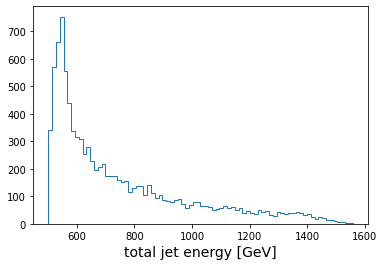

In [11]:
plt.hist(jet_energies, histtype='step', bins=80, log=False)
plt.xlabel("total jet energy [GeV]");

By default, when we apply math operations (such as addition, multiplication, etc) to arrays, the operation is performed **element-wise**. For example:

In [12]:
a = np.arange(5)
print(a)
print(a*a)

[0 1 2 3 4]
[ 0  1  4  9 16]


This allows us to do a lot of computations efficiently across entire arrays, without having to write loops. For example, the *magnitude* of the 3-momentum of each particle is |p|=sqrt(px^2 + py^2 + pz^2). In numpy we can do this by first computing the square of all the momentum components, and adding the components up along the last axis, and the taking the square root:

In [13]:
psquared_components = x[:,:,1:]**2
psquared_components.shape

(10000, 139, 3)

In [14]:
psquared = psquared_components.sum(axis=-1)
psquared.shape

(10000, 139)

In [15]:
pmag = np.sqrt(psquared)
pmag.shape

(10000, 139)

Now we have a value of |p| for each particle in each event. Alternatively, we could compute the total momentum *per event*; note that we should first add the vector elements of the particles element-wise!

In [16]:
jet_p = x[:,:,1:].sum(axis=1)
jet_p.shape

(10000, 3)

In [17]:
jet_pmag = np.sqrt(np.sum(jet_p**2, axis=1))
jet_pmag.shape

(10000,)

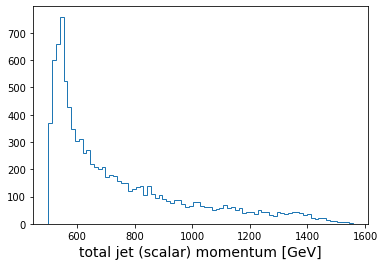

In [18]:
plt.hist(jet_pmag, histtype='step', bins=80)
plt.xlabel("total jet (scalar) momentum [GeV]");

It looks pretty similar to the energy distribution above. That's because these jets have relatively small mass compared to their momentum.

Recall from relativity that m^2 = E^2 - p^2; therefore, we can compute the **invariant mass** of each jet (i.e. the collection of particles) as follows:

In [19]:
jet_mass = np.sqrt(jet_energies**2 - jet_pmag**2)
jet_mass.shape

(10000,)

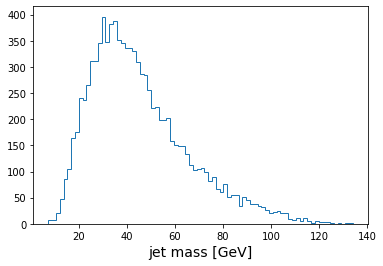

In [20]:
plt.hist(jet_mass, histtype='step', bins=80);
plt.xlabel("jet mass [GeV]");

Lastly, lets go back to detector coordinates (pt, eta, phi), and "center" all the particles about the jet axis. First, we compute the jet-level values for pt, eta, phi:

In [21]:
jpt = np.sqrt(np.sum(jet_p[:,:2]**2, axis=-1))
jphi = np.arctan2(jet_p[:,1],jet_p[:,0])
jeta = np.arcsinh(jet_p[:,2]/jpt)

Then we copy the original (pt,eta,phi) values for all the particles, and shift them so that the jet axis is centered at the origin.
Note that we have to take some care to avoid wrap-around effects in phi (otherwise you'll get values like ~2pi instead of ~0).
We also have to be sure to re-zero out the "missing particles", since all those zero values will be shifted.

In [22]:
x_center = x0[:,:,:3].copy()
missing_particles = x0[:,:,0]==0
x_center[:,:,1] -= jeta[:,np.newaxis]
x_center[:,:,2] -= jphi[:,np.newaxis]
x_center[:,:,2] = np.arctan2(np.sin(x_center[:,:,2]),np.cos(x_center[:,:,2]))

# let's zero-out all the particles that were empty in the original data
x_center[missing_particles] = 0

Now that we have all the jet particles in a "centered" coordinate system, we can try to visualize some jets in the eta-phi plane.
For this we can just make a 2D histogram, with entries weighted by the pT. Let's pick a few random jets from each category and look at their particles:

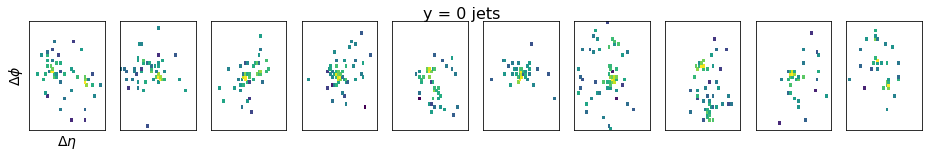

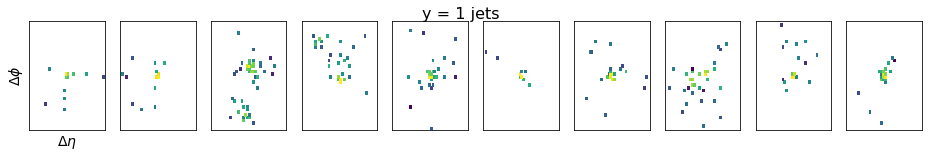

In [23]:
nplot = 10
ysel = 0
plt.figure(figsize=plt.figaspect(1/nplot))
for i in range(nplot):
    plt.subplot(1,nplot,i+1)
    plt.hist2d(x_center[y==ysel][i,:,1], x_center[y==ysel][i,:,2], weights=x_center[y==ysel][i,:,0], bins=40, range=[(-0.4,0.4),(-0.4,0.4)], norm=LogNorm(vmin=0.05,vmax=100));
    if i == 0:
        plt.xlabel(r"$\Delta\eta$")
        plt.ylabel(r"$\Delta\phi$")
    
    # turn off the axes numbers for tidiness:
    plt.gca().xaxis.set_ticks([])
    plt.gca().yaxis.set_ticks([])
plt.suptitle("y = %d jets"%(ysel), fontsize=16);

ysel = 1
plt.figure(figsize=plt.figaspect(1/nplot))
for i in range(nplot):
    plt.subplot(1,nplot,i+1)
    plt.hist2d(x_center[y==ysel][i,:,1], x_center[y==ysel][i,:,2], weights=x_center[y==ysel][i,:,0], bins=40, range=[(-0.4,0.4),(-0.4,0.4)], norm=LogNorm(vmin=0.05,vmax=100));
    if i == 0:
        plt.xlabel(r"$\Delta\eta$")
        plt.ylabel(r"$\Delta\phi$")
    
    # turn off the axes numbers for tidiness:
    plt.gca().xaxis.set_ticks([])
    plt.gca().yaxis.set_ticks([])
plt.suptitle("y = %d jets"%(ysel), fontsize=16);

Can you spot the difference between these jets? The goal is to train a NN to do it -- hopefully better than a human and certainly faster!

It can also helpful to look at a composite of many jets' eta/phi distribution. We can do that by simply adding all the jets together in the same histogram. The flatten() method is used to turn an N-d array into a 1D array with the same number of elements (since that is what hist2d expects as arguments). Note that since we're weighting by pT, the "missing" particles will not contribute.

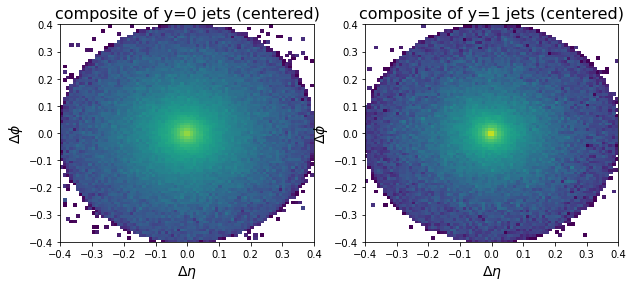

In [24]:
plt.figure(figsize=plt.figaspect(0.4))
plt.subplot(121)
plt.hist2d(x_center[y==0,:,1].flatten(), x_center[y==0,:,2].flatten(), weights=x_center[y==0,:,0].flatten(), bins=80, range=[(-0.4,0.4),(-0.4,0.4)], norm=LogNorm(vmin=0.5,vmax=1e6));
plt.title("composite of y=0 jets (centered)", fontsize=16)
plt.xlabel(r"$\Delta\eta$")
plt.ylabel(r"$\Delta\phi$")
plt.subplot(122)
plt.hist2d(x_center[y==1,:,1].flatten(), x_center[y==1,:,2].flatten(), weights=x_center[y==1,:,0].flatten(), range=[(-0.4,0.4),(-0.4,0.4)], bins=80, norm=LogNorm(vmin=0.5,vmax=1e6));
plt.title("composite of y=1 jets (centered)", fontsize=16);
plt.xlabel(r"$\Delta\eta$")
plt.ylabel(r"$\Delta\phi$");

The difference is fairly subtle -- mostly it seems like the gluon jets are more diffuse. A common approach to improve the usefulness of this visualization by orienting all the jets in the same way. That way, certain features won't get smeared and averaged out over the whole circle.

As we will see, one of the benefits of building an equivariant network is that it makes this step unecessary. But let's do it for the sake of visualization!

I'll leave this as a homework problem, but the steps are:

  * Center all the particles about their respective jet axes (we've already done this)
  * Identify the highest-pT particle in each jet, and apply a rotation in the eta/phi plane to all particles within the jet, such that the hardest particle lies on the positive-eta axis (i.e. it should have phi=0 after the rotation).
  * Identify the 2nd-highest-pT particle in each jet, and, if necessary, apply a reflection of all particles about the eta axis to ensure that this 2nd hardest particle is in the upper half of the plane.